<a href="https://colab.research.google.com/github/yl-code-it/Weld_Image_Generation_BAGAN-GP/blob/main/SCS_3546_Term_Project_Yu_Lin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning 3546 - Term Project 
# **Deep Learning of Good/Bad Weld Images Generation for Small and class-imbalanced Datasets using DCGAN and BAGAN-GP in Keras**
# Yu Lin

Good/Bad Weld image generation was explored using both DCGAN [1] as baseline model, and a newly proposed BAGAN-GP model in 2021 [2]. As a background, the collected weld images from the automotive production floor were imbalanced and relatively small-scale for defective image dataset. Also, the difference bewteen them are at the local weld seam area. The images could be similar if not pay enough attention. 

As a term project attempt of Deep Learning course, deep convolutional Generative adversarial networks (DCGANs) is applied to generate artificial weld data samples. From the testing, for the majority good weld images of size of 900, the DCGANs was able to generate not perfect but quite promissing images. But the DCGANs was not able to generate meaningful images for the minority defetive weld images due to very limit sample size of 117 images. To solve minority and similar image generation problem, therefore, the newly proposed balancing GAN and gradient penalty (BAGAN-GP) in 2021 is utilized herein to generate the minority-class but similar bad weld images. 

The main contributions of BAGAN-GP are: using a 'supervised' autoencoder with an intermediate embedding model to disperse the labeled latent vectors, which helps the autoencoder learn the label information directly. Then, use it to initialize the GAN training, which gives the GAN a common knowlege of all classes, even when the different class images are similar, 2. improve the loss function of BAGAN with gradient penalty and build the corresponding architecture of the generator and the discriminator (BAGAN-GP), which ensures a balanced training for each class [2]. 

# 1.  Deep Convolutional Generative Adversarial Networks (DCGANs) [1]

## Setup

In [ ]:
from datetime import datetime
import os
from glob import glob
from IPython import display
import imageio
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import PIL
from PIL import Image
import pytz
import random
from scipy import ndarray
import skimage as sk
from skimage import io
from skimage import util
from skimage import transform
import tensorflow as tf
from tensorflow.keras import layers
import time
import cv2

## Hyperparameters

In [ ]:
IMAGE_SIZE = 64
EPOCHS = 50
BATCH_SIZE = 64
DATASET_FOLDER = 'WeldIMG_input/'
LR_D = 0.00004
LR_G = 0.0004
BETA1 = 0.5
WEIGHT_INIT_STDDEV = 0.02
EPSILON = 0.00005

## Image presentation functions

In [ ]:
def generate_and_save_images(model, epoch, test_input, save_image=True):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      generated_image2 = predictions[i].numpy() * 127.5 + 127.5
      plt.imshow(generated_image2.astype('uint8'))

      plt.axis('off')

  if save_image:
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
def show_samples(sample_images):
    
    print("len(sample_images): ", len(sample_images))
    print("len(sample_images): ", sample_images[0].shape)
    
    figure, axes = plt.subplots(1, len(sample_images), figsize = (50, 50))

    print("figure: ", figure)
    print("axes: ", axes)

    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        axis.imshow(image_array) #, cmap='Greys_r'
        
    plt.show()
    plt.close()

In [ ]:
def show_samples2(sample_images):
    figure, axes = plt.subplots(1, len(sample_images), figsize = (50, 50))

    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        image_array = image_array.numpy() * 127.5 + 127.5
        axis.imshow(image_array.astype(np.uint8))

    plt.show()
    plt.close()

## Data Preparation

Mount the drive to upload the images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
ZIP_FILE = '/content/drive/My\ Drive/Colab\ Notebooks/RH16.zip'
!cp $ZIP_FILE .    
!unzip -q -o 'RH16.zip'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Create dataset of good and bad weld images. check the size of imbalanced image sets. 

In [ ]:
target_names = ["Good", "Bad"]
Good_data_dir = '/content/GOOD/'
Bad_data_dir = '/content/BAD/'
# generative folder set to bad welds
nb_good_samples = sum([len(files) for _, _, files in os.walk(Good_data_dir)])
nb_bad_samples = sum([len(files) for _, _, files in os.walk(Bad_data_dir)])
print('\n - names of classes: ', target_names)
print(' - # of GOOD WELD samples: ', nb_good_samples, '\n - # of BAD WELD samples: ', nb_bad_samples)


 - names of classes:  ['Good', 'Bad']
 - # of GOOD WELD samples:  900 
 - # of BAD WELD samples:  117


## Good weld images preparation
Create input good weld images of dataset with shape of 900x64x64x3

Input: (900, 64, 64, 3)
len(sample_images):  5
len(sample_images):  (64, 64, 3)
figure:  Figure(3600x3600)
axes:  [<matplotlib.axes._subplots.AxesSubplot object at 0x7f45382f6c50>


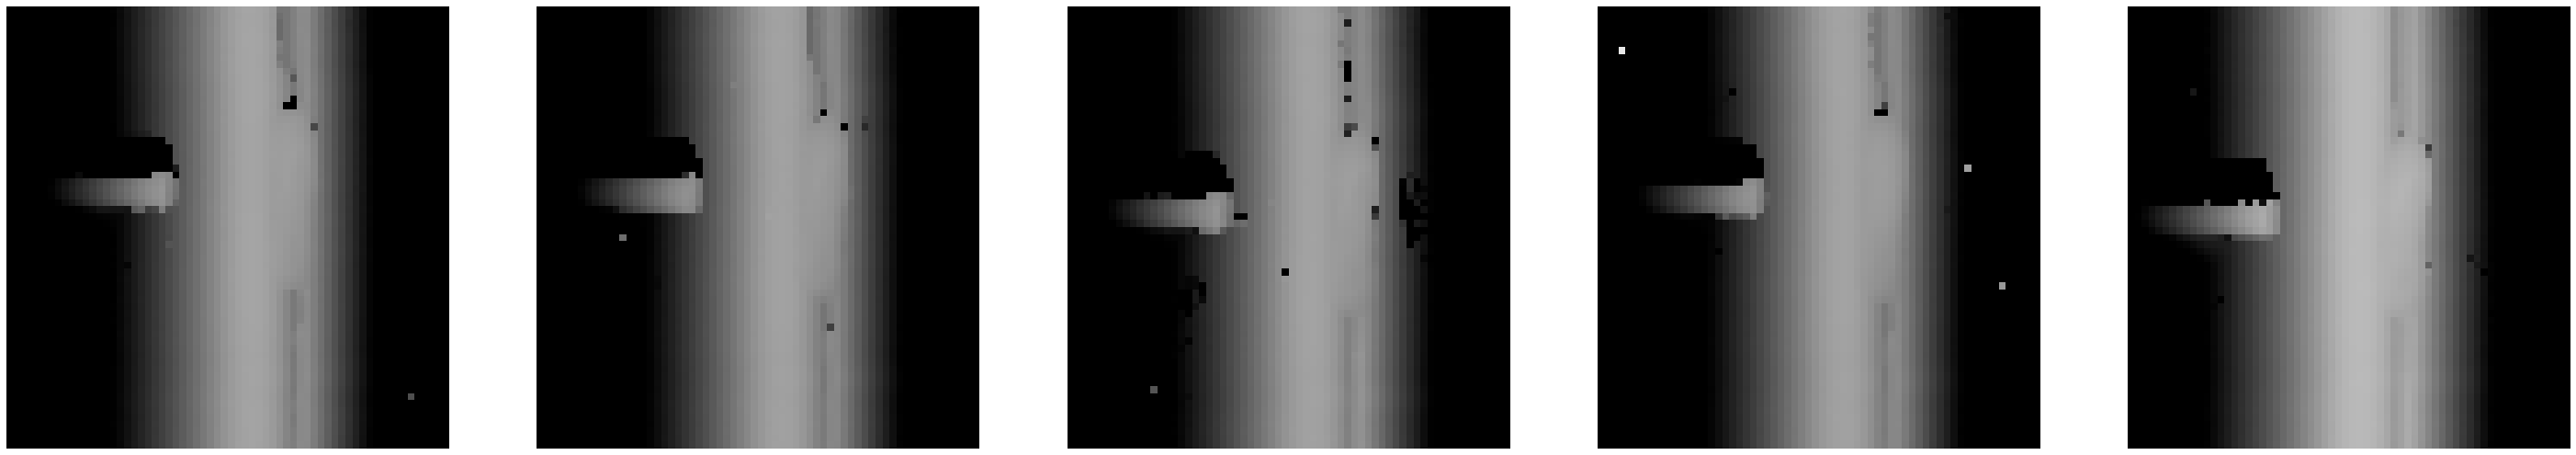

In [ ]:
input_images = np.asarray([np.asarray(
    cv2.resize(cv2.imread(file, cv2.IMREAD_UNCHANGED), (IMAGE_SIZE,IMAGE_SIZE))
    ) for file in glob(Good_data_dir+'*')])
print ("Input: " + str(input_images.shape))

np.random.shuffle(input_images)

sample_images = input_images[:5]
show_samples(sample_images)

Reshape GOOD images and cast to float32, and rescale value to [-1, 1]. shuffle and create batch dataset. 

In [ ]:
train_images = input_images.reshape(input_images.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5 

# Batch and shuffle the data
BUFFER_SIZE = input_images.shape[0]
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

verify the value is within [-1,1]

In [ ]:
train_images[0][0][32]

array([0.23137255, 0.23137255, 0.23137255], dtype=float32)

In [ ]:
train_dataset

<BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

## Bad weld images preparation
Create input BAD weld images of dataset with shape of 117x64x64x3

Input of bad images: (117, 64, 64, 3)
len(sample_images):  5
len(sample_images):  (64, 64, 3)
figure:  Figure(3600x3600)
axes:  [<matplotlib.axes._subplots.AxesSubplot object at 0x7f44a5485490>


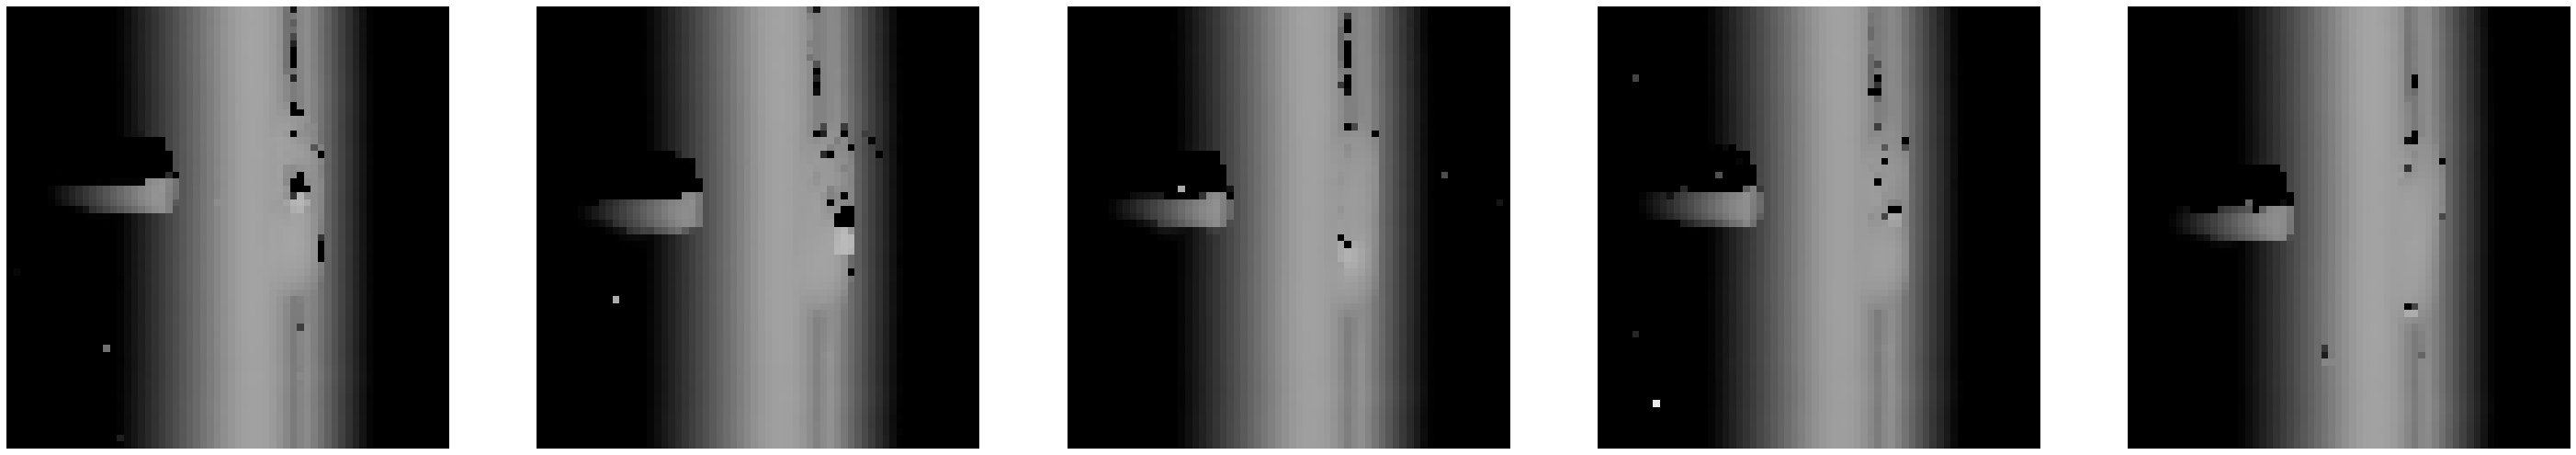

In [ ]:
input_images_bad = np.asarray([np.asarray(
    cv2.resize(cv2.imread(file, cv2.IMREAD_UNCHANGED), (IMAGE_SIZE,IMAGE_SIZE))
    ) for file in glob(Bad_data_dir+'*')])
print ("Input of bad images: " + str(input_images_bad.shape))

np.random.shuffle(input_images_bad)

sample_images_bad = input_images_bad[:5]
show_samples(sample_images_bad)

Reshape BAD images and cast to float32, and rescale value to [-1, 1]. shuffle and create batch dataset. 

In [ ]:
train_images_bad = input_images_bad.reshape(input_images_bad.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3).astype('float32')
train_images_bad = (train_images_bad - 127.5) / 127.5 

# Batch and shuffle the data
BUFFER_SIZE = input_images_bad.shape[0]
train_dataset_bad = tf.data.Dataset.from_tensor_slices(train_images_bad).shuffle(BUFFER_SIZE).batch(117)

In [ ]:
train_images_bad[0][0][32]

array([0.20784314, 0.20784314, 0.20784314], dtype=float32)

In [ ]:
train_dataset_bad

<BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

## DCGANs Model


### Generator

The generator takes codings of size 100, and it projects them to 16*16*256 dimensions of dense layer, and is batch normalized, then reshapes the results to get a 16x16x256 tensor. The tensor is fed to a transposed convolutional layer with a stride of 1, and reduces its depth from 256 to 128. The result is batch normalized again and fed to another transposed convolutional layer with a stride of 2, which upsamples it from 16x16 to 32x32 and further reduces the depth from 128 to 64. The result is batch normalized again and fed to final transposed convolutional layer with a stride of 2, which again upsamples it from 32x32 to 64x64 and further reduces the depth from 64 to 3, which is the channel size of final image. The output shape is 64x64x3. Note that the final activation is 'tanh', which outputs range from -1 to 1. The training images were reshaped to the same shape and range [1].

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(16*16*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((16, 16, 256)))
    assert model.output_shape == (None, 16, 16, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

Let's try generate a image using the above generator with normal distribution noise of size of 100. 

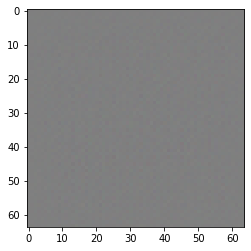

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

generated_image2 = generated_image[0].numpy() * 127.5 + 127.5

plt.imshow(generated_image2.astype('uint8'))

### Discriminator
The discriminator looks much like a regular CNN for binary classification, except instead of using max pooling layers to downsmaple the image, we use strided convolution with stride of 2. Also note that we use the leaky ReLU activiation function. 

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00141061]], shape=(1, 1), dtype=float32)


### Define the loss and optimizers

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss
This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Define the training loop

In [ ]:
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
def summarize_epoch(epoch, d_losses, g_losses, save_image=True):
  
    fig, ax = plt.subplots()
    plt.plot(d_losses, label='Discriminator', alpha=0.6)
    plt.plot(g_losses, label='Generator', alpha=0.6)
    plt.title("Losses")
    plt.legend()
    if save_image:
        plt.savefig("losses_" + str(epoch) + ".png")
    plt.show()
    plt.close()
    

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

Finalize the training model with time and image tracking functions during each epoch. The loss of generator and discriminator are both monitored during each epoch. The images generator generated are saved to create a GIF every 15 epochs. 

In [ ]:
tz_NY = pytz.timezone('America/New_York') 

In [ ]:
def train(dataset, epochs):
  print('Training started at: ', datetime.now(tz_NY))
  save_image = False
  d_losses = []
  g_losses = []
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      d_loss, g_loss = train_step(image_batch)
      d_losses.append(d_loss)
      g_losses.append(g_loss)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      save_image = True

    generate_and_save_images(generator,
                             epoch + 1,
                             seed,
                             save_image)
    summarize_epoch(epoch, d_losses, g_losses, save_image)
    save_image = False
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  summarize_epoch(epoch, d_losses, g_losses)

## Train the model of GOOD weld images
For the majority good weld images of size of 900, the DCGANs was able to generate not perfect but quite promissing images. 

Call the train() method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated images will look increasingly real. After about 50 epochs, they resemble GOOD Weld images. This may take about one minute / epoch with the default settings on Colab.

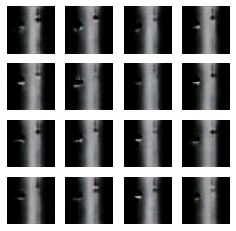

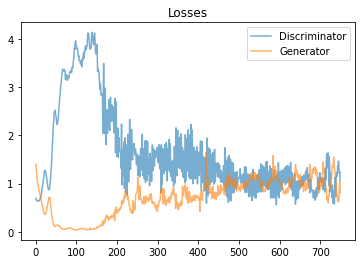

In [ ]:
train(train_dataset, EPOCHS)

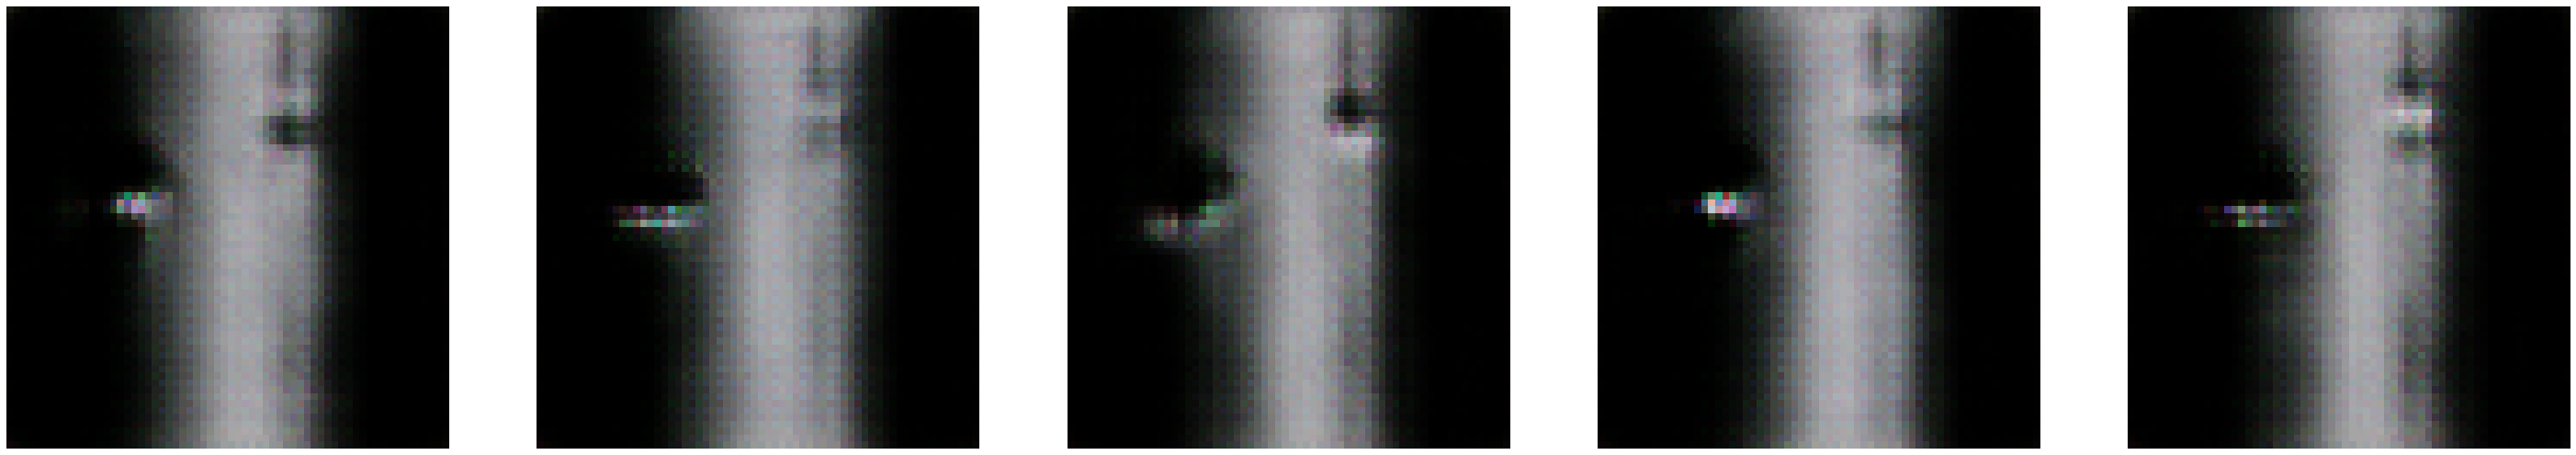

In [ ]:
noise = tf.random.normal([5, 100])
generated_image = generator(noise, training=False)
show_samples2(generated_image)

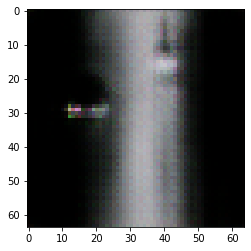

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image2 = generated_image[0].numpy() * 127.5 + 127.5

plt.imshow(generated_image2.astype(np.uint8))
plt.show()
plt.close()

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

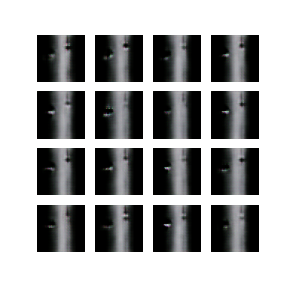

In [ ]:
display_image(EPOCHS)

### Create a GIF

Use imageio to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [ ]:
# to generate gifs
! pip install imageio
! pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-dak2fb96
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-dak2fb96
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=180247 sha256=8d5eeca7daf8e8feb87370aa24e803f1496528a642f724ac77146c5347eec1ee
  Stored in directory: /tmp/pip-ephem-wheel-cache-m618vgi8/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs



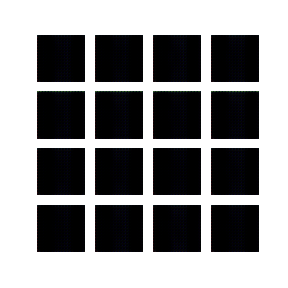

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

## Train the model of BAD weld images
From the testing, the DCGANs was not able to generate meaningful images for the minority defetive weld images due to very limit sample size of 117 images.

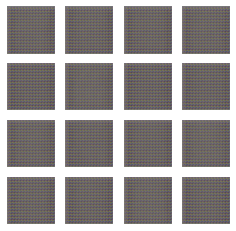

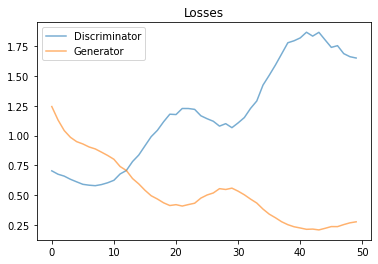

In [ ]:
train(train_dataset_bad, EPOCHS)

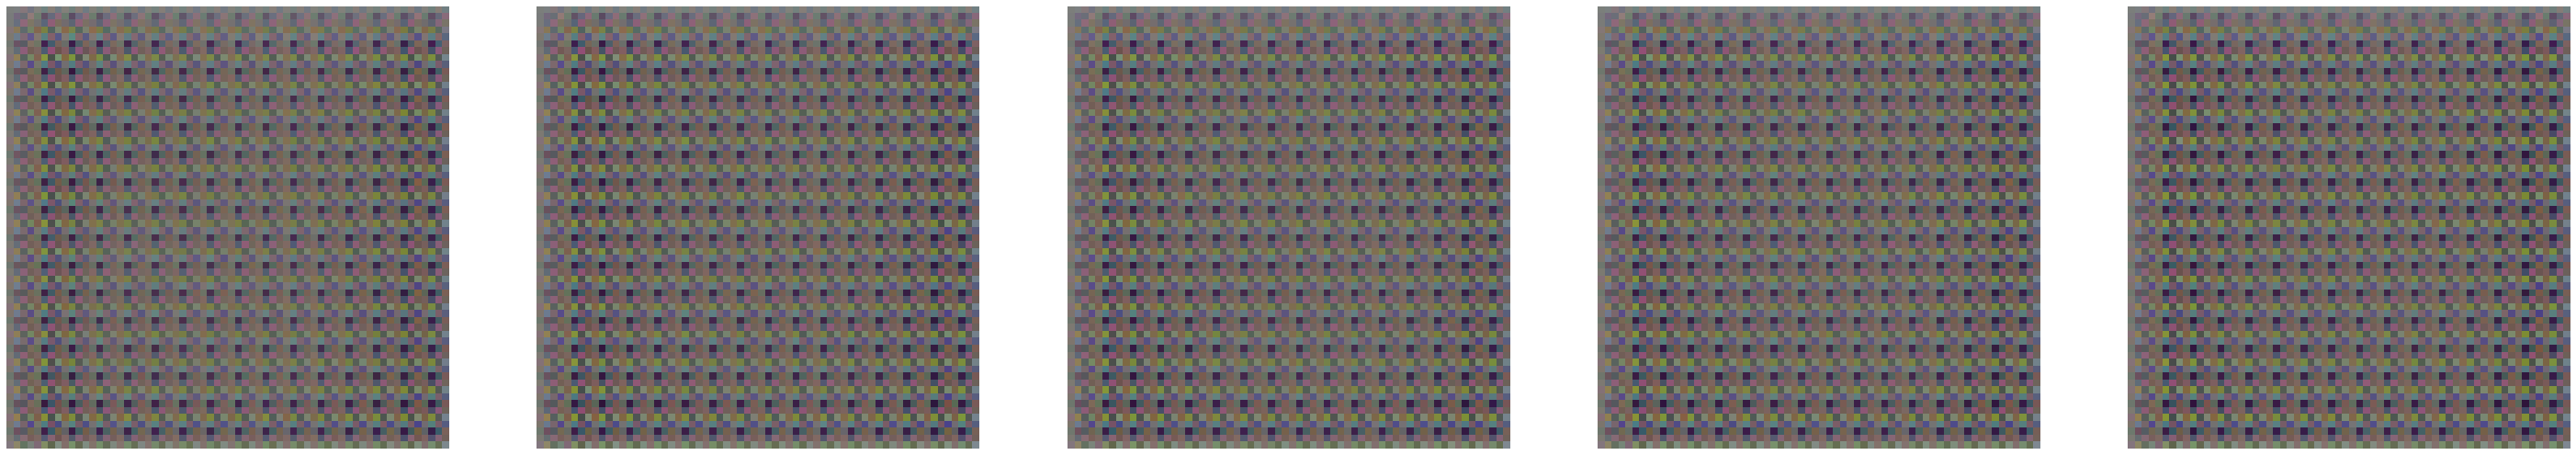

In [ ]:
noise = tf.random.normal([5, 100])
generated_image = generator(noise, training=False)
show_samples2(generated_image)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [ ]:
# to generate gifs
! pip install imageio
! pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-vsxslumh
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-vsxslumh
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=180247 sha256=0a3295a3d5df335fc480a5e7000612200158b69a1eb89bdf1c97f30f7ce6a768
  Stored in directory: /tmp/pip-ephem-wheel-cache-6ha_d5b_/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


### Create a GIF


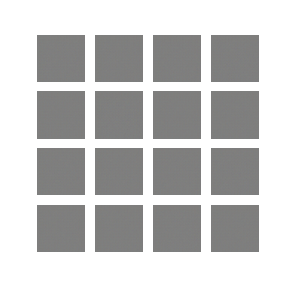

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

## Summary of DCGANs testing for weld images generation
Apperantly, in order to get a realistic weld images, we have to gather enough image dataset, for example 900 good weld images in the testing. But it did not work for small bad weld images of 117. The good and bad images could be combined and train together. However, similar results would be expected as of very few bad weld images - imbalanced and small datasets. 


# 2. Balancing GAN and gradient penalty (BAGAN-GP) [2]
BAGAN has two key steps comparing with ordinary conditional GAN: autoencoder initialization and labeled latent generation. 

In [ ]:
# %% --------------------------------------- Load Packages -------------------------------------------------------------
import os
import random
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Input, Reshape, Dense, Dropout, \
    Activation, LeakyReLU, Conv2D, Conv2DTranspose, Embedding, \
    Concatenate, multiply, Flatten, BatchNormalization
from tensorflow.keras.initializers import glorot_normal
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm

In [ ]:
# %% --------------------------------------- Fix Seeds -----------------------------------------------------------------
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
weight_init = glorot_normal(seed=SEED)

 ## Data Preparation
BAGAN-GP requires labels to train the autoencoder with an intermediate embedding model, which helps the autoencoder learn the label information directly. 

In [ ]:
def assigning_label(img,weld_type):
  weld_label = 0
  if weld_type == "Good":
    weld_label = 1
  return weld_label

def make_train_data(weld_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assigning_label(img,weld_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        y.append(label)

X=[]
y=[]
IMG_SIZE=64

In [ ]:
#create training data
make_train_data('Good',Good_data_dir)
make_train_data('Bad',Bad_data_dir)
print(len(X))

X = np.array(X)
y = np.array(y)

100%|██████████| 117/117 [00:00<00:00, 2637.81it/s]

1017


## Preprocessing

In [ ]:
# Set channel and dataset
channel = 3
images = X
labels = y

# Train test split, for autoencoder (actually, this step is redundant if we already have test set)
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, shuffle=True, random_state=SEED)

# It is suggested to use [-1, 1] input for GAN training
x_train = (x_train.astype('float32') - 127.5) / 127.5
x_test = (x_test.astype('float32') - 127.5) / 127.5

# Get image size
img_size = x_train[0].shape
# Get number of classes
n_classes = len(np.unique(y_train))

In [ ]:
x_train.shape

(711, 64, 64, 3)

In [ ]:
x_test.shape

(306, 64, 64, 3)

In [ ]:
y_train.shape

(711,)

In [ ]:
y_test.shape

(306,)

## Hyperparameters

In [ ]:
optimizer = Adam(lr=0.0002, beta_1=0.5, beta_2=0.9)
latent_dim=128
# trainRatio === times(Train D) / times(Train G)
trainRatio = 5

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Generator Models Setup
Supervised autoencoder initialization helps generator and discriminator to build a common knowledge of the dataset among all classes. Besides, auoencoder will lead the initialized GAN to a good and stable solution. Also, an embedding model is used to generate the labeled latent vectors, which is calcualted by means and covariances of encoded training data. 

### Build Generator/Decoder

In [ ]:
# Build Generator/Decoder
def decoder():
    # weight initialization
    init = RandomNormal(stddev=0.02)

    noise_le = Input((latent_dim,))

    x = Dense(4*4*256)(noise_le)
    x = LeakyReLU(alpha=0.2)(x)

    ## Size: 4 x 4 x 256
    x = Reshape((4, 4, 256))(x)

    ## Size: 8 x 8 x 128
    x = Conv2DTranspose(filters=128,
                        kernel_size=(4, 4),
                        strides=(2, 2),
                        padding='same',
                        kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    ## Size: 16 x 16 x 128
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    ## Size: 32 x 32 x 64
    x = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    ## Size: 64 x 64 x 3
    generated = Conv2DTranspose(channel, (4, 4), strides=(2, 2), padding='same', activation='tanh', kernel_initializer=init)(x)


    generator = Model(inputs=noise_le, outputs=generated)
    return generator


### Build Encoder

In [ ]:
# Build Encoder
def encoder():
    # weight initialization
    init = RandomNormal(stddev=0.02)

    img = Input(img_size)

    x = Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(img)
    # x = LayerNormalization()(x) # It is not suggested to use BN in Discriminator of WGAN
    x = LeakyReLU(0.2)(x)
    # x = Dropout(0.3)(x)

    x = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(x)
    # x = LayerNormalization()(x)
    x = LeakyReLU(0.2)(x)
    # x = Dropout(0.3)(x)

    x = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(x)
    # x = LayerNormalization()(x)
    x = LeakyReLU(0.2)(x)
    # x = Dropout(0.3)(x)

    x = Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(x)
    # x = LayerNormalization()(x)
    x = LeakyReLU(0.2)(x)
    # x = Dropout(0.3)(x)

    # 4 x 4 x 256
    feature = Flatten()(x)

    feature = Dense(latent_dim)(feature)
    out = LeakyReLU(0.2)(feature)

    model = Model(inputs=img, outputs=out)
    return model

### Build Embedding model

In [ ]:
# Build Embedding model
def embedding_labeled_latent():
    # # weight initialization
    # init = RandomNormal(stddev=0.02)

    label = Input((1,), dtype='int32')
    noise = Input((latent_dim,))
    # ne = Dense(256)(noise)
    # ne = LeakyReLU(0.2)(ne)

    le = Flatten()(Embedding(n_classes, latent_dim)(label))
    # le = Dense(256)(le)
    # le = LeakyReLU(0.2)(le)

    noise_le = multiply([noise, le])
    # noise_le = Dense(latent_dim)(noise_le)

    model = Model([noise, label], noise_le)

    return model

### Build Autoencoder

In [ ]:
# Build Autoencoder
def autoencoder_trainer(encoder, decoder, embedding):

    label = Input((1,), dtype='int32')
    img = Input(img_size)

    latent = encoder(img)
    labeled_latent = embedding([latent, label])
    rec_img = decoder(labeled_latent)
    model = Model([img, label], rec_img)

    model.compile(optimizer=optimizer, loss='mae')
    return model

### Train Autoencoder

In [ ]:
# Train Autoencoder
en = encoder()
de = decoder()
em = embedding_labeled_latent()
ae = autoencoder_trainer(en, de, em)

ae.fit([x_train, y_train], x_train,
       epochs=30,
       batch_size=128,
       shuffle=True,
       validation_data=([x_test, y_test], x_test))


Epoch 1/30
6/6 [==============================] - 21s 3s/step - loss: 0.5957 - val_loss: 0.6298
Epoch 2/30
6/6 [==============================] - 17s 3s/step - loss: 0.4582 - val_loss: 0.6284
Epoch 3/30
6/6 [==============================] - 17s 3s/step - loss: 0.3474 - val_loss: 0.6266
Epoch 4/30
6/6 [==============================] - 16s 3s/step - loss: 0.2651 - val_loss: 0.6244
Epoch 5/30
6/6 [==============================] - 16s 3s/step - loss: 0.2031 - val_loss: 0.6216
Epoch 6/30
6/6 [==============================] - 16s 3s/step - loss: 0.1551 - val_loss: 0.6180
Epoch 7/30
6/6 [==============================] - 16s 3s/step - loss: 0.1226 - val_loss: 0.6134
Epoch 8/30
6/6 [==============================] - 17s 3s/step - loss: 0.1004 - val_loss: 0.6083
Epoch 9/30
6/6 [==============================] - 16s 3s/step - loss: 0.0845 - val_loss: 0.6025
Epoch 10/30
6/6 [==============================] - 15s 3s/step - loss: 0.0715 - val_loss: 0.5960
Epoch 11/30
6/6 [======================

### Show results of reconstructed images

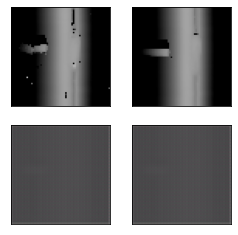

In [ ]:
# Show results of reconstructed images in test dataset
decoded_imgs = ae.predict([x_test, y_test])
n = n_classes
plt.figure(figsize=(2*n, 4))
decoded_imgs = decoded_imgs*0.5 + 0.5
x_real = x_test*0.5 + 0.5
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    if channel == 3:
        plt.imshow(x_real[y_test==i][0].reshape(64, 64, channel))
    else:
        plt.imshow(x_real[y_test==i][0].reshape(64, 64))
        plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    if channel == 3:
        plt.imshow(decoded_imgs[y_test==i][0].reshape(64, 64, channel))
    else:
        plt.imshow(decoded_imgs[y_test==i][0].reshape(64, 64))
        plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


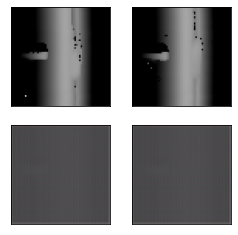

In [ ]:
# Show results of reconstructed images in training dataset
decoded_imgs = ae.predict([x_train, y_train])
n = n_classes
plt.figure(figsize=(2*n, 4))
decoded_imgs = decoded_imgs*0.5 + 0.5
x_real = x_train*0.5 + 0.5
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    if channel == 3:
        plt.imshow(x_real[y_train==i][0].reshape(64, 64, channel))
    else:
        plt.imshow(x_real[y_train==i][0].reshape(64, 64))
        plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    if channel == 3:
        plt.imshow(decoded_imgs[y_train==i][0].reshape(64, 64, channel))
    else:
        plt.imshow(decoded_imgs[y_train==i][0].reshape(64, 64))
        plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


## Build Discriminator - cWGAN

In [ ]:
####################### Use the pre-trained Autoencoder #########################
# from tensorflow.keras.models import load_model
# en = load_model('bagan_gp_encoder.h5')
# em = load_model('bagan_gp_embedding.h5')
# de = load_model('bagan_gp_decoder.h5')

# Build Discriminator without inheriting the pre-trained Encoder
# Similar to cWGAN
def discriminator_cwgan():
    # weight initialization
    init = RandomNormal(stddev=0.02)

    img = Input(img_size)
    label = Input((1,), dtype='int32')


    x = Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(img)
    # x = LayerNormalization()(x) # It is not suggested to use BN in Discriminator of WGAN
    x = LeakyReLU(0.2)(x)
    # x = Dropout(0.3)(x)

    x = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(x)
    # x = LayerNormalization()(x)
    x = LeakyReLU(0.2)(x)
    # x = Dropout(0.3)(x)

    x = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(x)
    # x = LayerNormalization()(x)
    x = LeakyReLU(0.2)(x)
    # x = Dropout(0.3)(x)

    x = Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(x)
    # x = LayerNormalization()(x)
    x = LeakyReLU(0.2)(x)
    # x = Dropout(0.3)(x)

    x = Flatten()(x)

    le = Flatten()(Embedding(n_classes, 512)(label))
    le = Dense(4 * 4 * 256)(le)
    le = LeakyReLU(0.2)(le)
    x_y = multiply([x, le])
    x_y = Dense(512)(x_y)

    out = Dense(1)(x_y)

    model = Model(inputs=[img, label], outputs=out)

    return model

## Build our BAGAN-GP

In [ ]:
# %% ----------------------------------- BAGAN-GP Part -----------------------------------------------------------------
# Refer to the WGAN-GP Architecture. https://github.com/keras-team/keras-io/blob/master/examples/generative/wgan_gp.py
# Build our BAGAN-GP
class BAGAN_GP(Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(BAGAN_GP, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.train_ratio = trainRatio
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(BAGAN_GP, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images, labels):
        """ Calculates the gradient penalty.
        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # get the interplated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator([interpolated, labels], training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calcuate the norm of the gradients
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        if isinstance(data, tuple):
            real_images = data[0]
            labels = data[1]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        ########################### Train the Discriminator ###########################
        # For each batch, we are going to perform cwgan-like process
        for i in range(self.train_ratio):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            fake_labels = tf.random.uniform((batch_size,), 0, n_classes)
            wrong_labels = tf.random.uniform((batch_size,), 0, n_classes)
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator([random_latent_vectors, fake_labels], training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator([fake_images, fake_labels], training=True)
                # Get the logits for real images
                real_logits = self.discriminator([real_images, labels], training=True)
                # Get the logits for wrong label classification
                wrong_label_logits = self.discriminator([real_images, wrong_labels], training=True)

                # Calculate discriminator loss using fake and real logits
                d_cost = self.d_loss_fn(real_logits=real_logits, fake_logits=fake_logits,
                                        wrong_label_logits=wrong_label_logits
                                        )

                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images, labels)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        ########################### Train the Generator ###########################
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        fake_labels = tf.random.uniform((batch_size,), 0, n_classes)
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator([random_latent_vectors, fake_labels], training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator([generated_images, fake_labels], training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}


## Optimizer for both the networks

In [ ]:
# Optimizer for both the networks
# learning_rate=0.0002, beta_1=0.5, beta_2=0.9 are recommended
generator_optimizer = Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

## Loss function

In [ ]:
# We refer to the DRAGAN loss function. https://github.com/kodalinaveen3/DRAGAN
# Define the loss functions to be used for discrimiator
# We will add the gradient penalty later to this loss function
def discriminator_loss(real_logits, fake_logits, wrong_label_logits):
    real_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logits, labels=tf.ones_like(real_logits)))
    fake_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.zeros_like(fake_logits)))
    wrong_label_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=wrong_label_logits, labels=tf.zeros_like(fake_logits)))

    return wrong_label_loss + fake_loss + real_loss

# Define the loss functions to be used for generator
def generator_loss(fake_logits):
    fake_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.ones_like(fake_logits)))
    return fake_loss

# build generator with pretrained decoder and embedding
def generator_label(embedding, decoder):
    # # Embedding model needs to be trained along with GAN training
    # embedding.trainable = False

    label = Input((1,), dtype='int32')
    latent = Input((latent_dim,))

    labeled_latent = embedding([latent, label])
    gen_img = decoder(labeled_latent)
    model = Model([latent, label], gen_img)

    return model

In [ ]:
# Build discriminator with pre-trained Encoder
def build_discriminator(encoder):

    label = Input((1,), dtype='int32')
    img = Input(img_size)

    inter_output_model = Model(inputs=encoder.input, outputs=encoder.layers[-3].output)
    x = inter_output_model(img)

    le = Flatten()(Embedding(n_classes, 512)(label))
    le = Dense(4 * 4 * 256)(le)
    le = LeakyReLU(0.2)(le)
    x_y = multiply([x, le])
    x_y = Dense(512)(x_y)

    out = Dense(1)(x_y)

    model = Model(inputs=[img, label], outputs=out)

    return model


## Compile Models

In [ ]:
# %% ----------------------------------- Compile Models ----------------------------------------------------------------
# d_model = build_discriminator(en)  # initialized with Encoder
d_model = discriminator_cwgan()  # without initialization
g_model = generator_label(em, de)  # initialized with Decoder and Embedding

bagan_gp = BAGAN_GP(
    discriminator=d_model,
    generator=g_model,
    latent_dim=latent_dim,
    discriminator_extra_steps=3,
)

# Compile the model
bagan_gp.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

## Start Training

In [ ]:
# %% ----------------------------------- Start Training ----------------------------------------------------------------
# Plot/save generated images through training
def plt_img(generator, epoch):
    np.random.seed(42)
    latent_gen = np.random.normal(size=(n_classes, latent_dim))

    x_real = x_test * 0.5 + 0.5
    n = n_classes

    plt.figure(figsize=(2*n, 2*(n+1)))
    for i in range(n):
        # display original
        ax = plt.subplot(n+1, n, i + 1)
        if channel == 3:
            plt.imshow(x_real[y_test==i][4].reshape(64, 64, channel))
        else:
            plt.imshow(x_real[y_test == i][4].reshape(64, 64))
            plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        for c in range(n):
            decoded_imgs = generator.predict([latent_gen, np.ones(n)*c])
            decoded_imgs = decoded_imgs * 0.5 + 0.5
            # display generation
            ax = plt.subplot(n+1, n, (i+1)*n + 1 + c)
            if channel == 3:
                plt.imshow(decoded_imgs[i].reshape(64, 64, channel))
            else:
                plt.imshow(decoded_imgs[i].reshape(64, 64))
                plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.savefig('bagan_gp_results/generated_plot_%d.png' % epoch)
    plt.show()
    return

# make directory to store results
os.system('mkdir -p bagan_gp_results')

# Record the loss
d_loss_history = []
g_loss_history = []

LEARNING STEP #  1 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 201s 31s/step - d_loss: 7.4732 - g_loss: 1.6078
Epoch 2/2
6/6 [==============================] - 209s 35s/step - d_loss: 1.6136 - g_loss: 4.1576


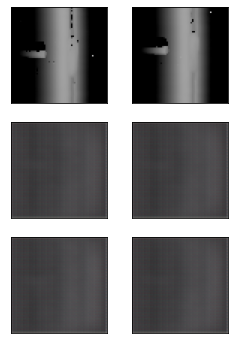

LEARNING STEP #  2 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 205s 34s/step - d_loss: 1.3936 - g_loss: 4.0017
Epoch 2/2
6/6 [==============================] - 192s 31s/step - d_loss: 1.3375 - g_loss: 4.7178


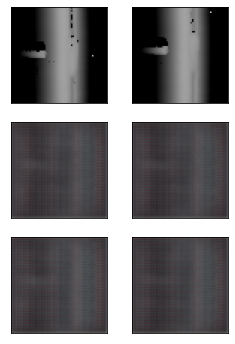

LEARNING STEP #  3 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 189s 31s/step - d_loss: 1.3263 - g_loss: 6.7311
Epoch 2/2
6/6 [==============================] - 186s 30s/step - d_loss: 1.3441 - g_loss: 4.4401


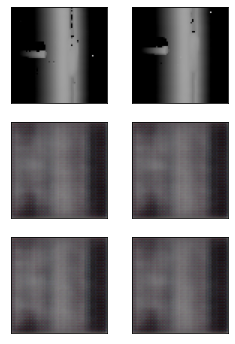

LEARNING STEP #  4 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 219s 37s/step - d_loss: 1.4172 - g_loss: 4.1313
Epoch 2/2
6/6 [==============================] - 208s 33s/step - d_loss: 1.3539 - g_loss: 3.7616


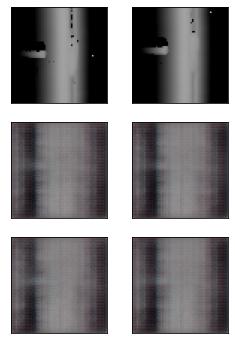

LEARNING STEP #  5 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 190s 31s/step - d_loss: 1.5004 - g_loss: 2.6641
Epoch 2/2
6/6 [==============================] - 191s 31s/step - d_loss: 1.6592 - g_loss: 2.9150


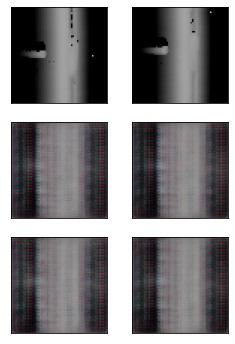

LEARNING STEP #  6 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 188s 31s/step - d_loss: 1.4447 - g_loss: 2.2272
Epoch 2/2
6/6 [==============================] - 229s 36s/step - d_loss: 1.4683 - g_loss: 2.7639


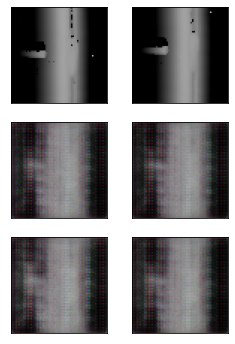

LEARNING STEP #  7 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 199s 33s/step - d_loss: 1.4930 - g_loss: 2.5485
Epoch 2/2
6/6 [==============================] - 192s 32s/step - d_loss: 1.5509 - g_loss: 2.2005


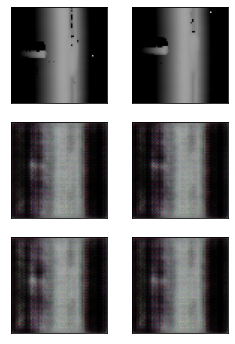

LEARNING STEP #  8 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 190s 31s/step - d_loss: 1.4986 - g_loss: 2.1935
Epoch 2/2
6/6 [==============================] - 193s 32s/step - d_loss: 1.4645 - g_loss: 2.1730


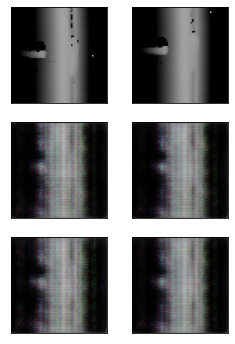

LEARNING STEP #  9 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 190s 31s/step - d_loss: 1.4698 - g_loss: 2.5034
Epoch 2/2
6/6 [==============================] - 189s 31s/step - d_loss: 1.4458 - g_loss: 2.3092


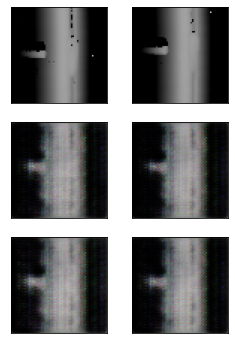

LEARNING STEP #  10 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 188s 31s/step - d_loss: 1.4382 - g_loss: 2.3450
Epoch 2/2
6/6 [==============================] - 193s 32s/step - d_loss: 1.5598 - g_loss: 2.2889


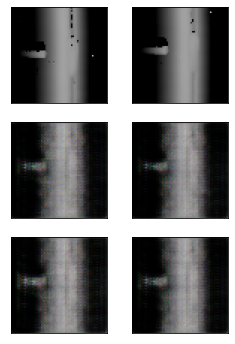

LEARNING STEP #  11 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 191s 31s/step - d_loss: 1.4731 - g_loss: 2.2845
Epoch 2/2
6/6 [==============================] - 188s 31s/step - d_loss: 1.4448 - g_loss: 2.4424


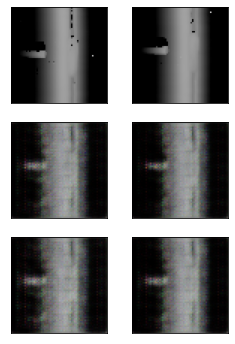

LEARNING STEP #  12 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 187s 31s/step - d_loss: 1.4738 - g_loss: 2.4005
Epoch 2/2
6/6 [==============================] - 188s 31s/step - d_loss: 1.4185 - g_loss: 2.2441


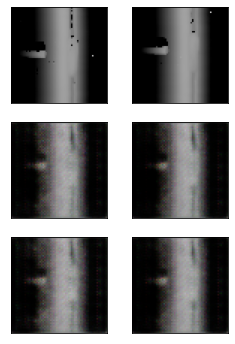

LEARNING STEP #  13 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 215s 36s/step - d_loss: 1.4010 - g_loss: 2.3354
Epoch 2/2
6/6 [==============================] - 186s 30s/step - d_loss: 1.4628 - g_loss: 2.3128


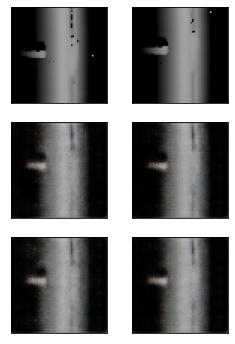

LEARNING STEP #  14 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 182s 30s/step - d_loss: 1.4476 - g_loss: 2.4067
Epoch 2/2
6/6 [==============================] - 182s 30s/step - d_loss: 1.4119 - g_loss: 2.2702


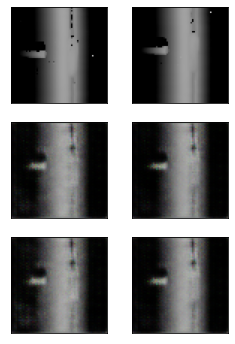

LEARNING STEP #  15 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 198s 33s/step - d_loss: 1.4571 - g_loss: 2.6011
Epoch 2/2
6/6 [==============================] - 190s 31s/step - d_loss: 1.3499 - g_loss: 2.4227


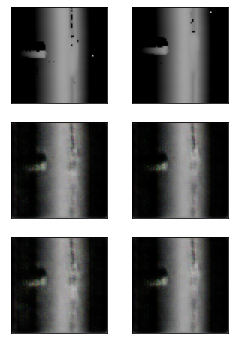

LEARNING STEP #  16 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 184s 30s/step - d_loss: 1.2968 - g_loss: 2.5466
Epoch 2/2
6/6 [==============================] - 180s 30s/step - d_loss: 1.3192 - g_loss: 2.7285


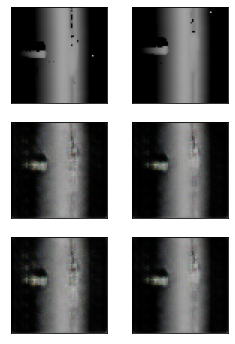

LEARNING STEP #  17 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 180s 29s/step - d_loss: 1.3022 - g_loss: 2.4989
Epoch 2/2
6/6 [==============================] - 179s 29s/step - d_loss: 1.2927 - g_loss: 2.4939


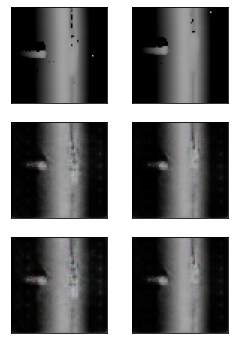

LEARNING STEP #  18 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 180s 30s/step - d_loss: 1.3020 - g_loss: 2.6256
Epoch 2/2
6/6 [==============================] - 178s 29s/step - d_loss: 1.2722 - g_loss: 2.7157


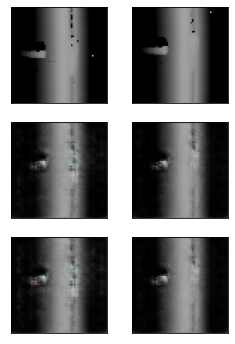

LEARNING STEP #  19 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 184s 30s/step - d_loss: 1.2370 - g_loss: 2.8217
Epoch 2/2
6/6 [==============================] - 422s 74s/step - d_loss: 1.2496 - g_loss: 2.7224


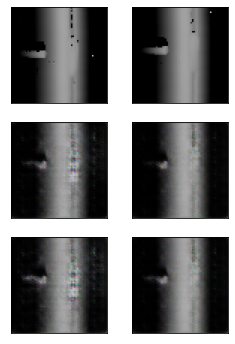

LEARNING STEP #  20 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 216s 34s/step - d_loss: 1.2637 - g_loss: 2.8141
Epoch 2/2
6/6 [==============================] - 188s 31s/step - d_loss: 1.2834 - g_loss: 2.7776


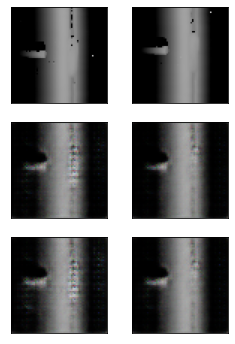

LEARNING STEP #  21 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 181s 30s/step - d_loss: 1.2833 - g_loss: 3.0199
Epoch 2/2
6/6 [==============================] - 180s 29s/step - d_loss: 1.2318 - g_loss: 2.8573


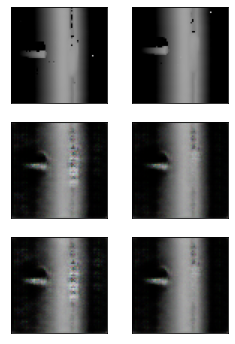

LEARNING STEP #  22 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 183s 30s/step - d_loss: 1.1967 - g_loss: 2.7610
Epoch 2/2
6/6 [==============================] - 182s 30s/step - d_loss: 1.2680 - g_loss: 2.5117


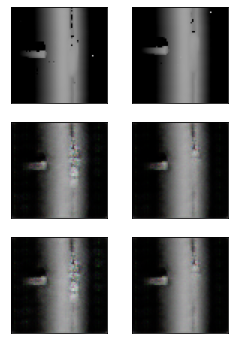

LEARNING STEP #  23 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 182s 30s/step - d_loss: 1.2388 - g_loss: 2.9924
Epoch 2/2
6/6 [==============================] - 182s 30s/step - d_loss: 1.2310 - g_loss: 2.8459


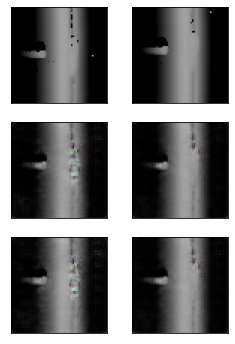

LEARNING STEP #  24 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 180s 30s/step - d_loss: 1.1999 - g_loss: 2.5524
Epoch 2/2
6/6 [==============================] - 180s 30s/step - d_loss: 1.2333 - g_loss: 2.7755


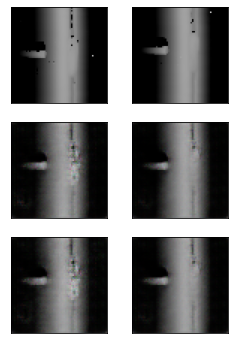

LEARNING STEP #  25 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 180s 30s/step - d_loss: 1.2129 - g_loss: 3.0246
Epoch 2/2
6/6 [==============================] - 180s 30s/step - d_loss: 1.2197 - g_loss: 3.0354


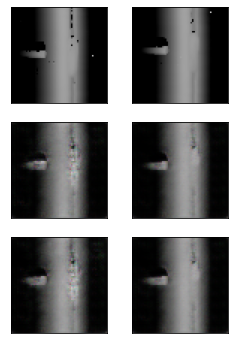

LEARNING STEP #  26 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 180s 30s/step - d_loss: 1.1906 - g_loss: 3.0329
Epoch 2/2
6/6 [==============================] - 179s 29s/step - d_loss: 1.2300 - g_loss: 2.7770


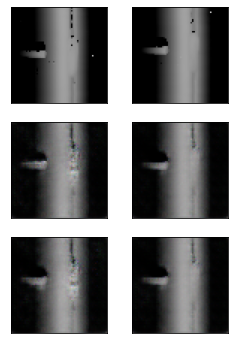

LEARNING STEP #  27 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 180s 29s/step - d_loss: 1.2426 - g_loss: 2.9287
Epoch 2/2
6/6 [==============================] - 180s 29s/step - d_loss: 1.2037 - g_loss: 2.8420


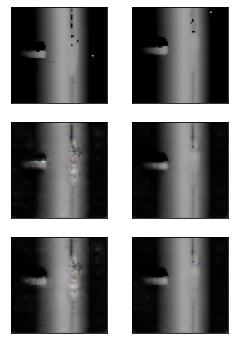

LEARNING STEP #  28 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 179s 30s/step - d_loss: 1.2108 - g_loss: 3.1092
Epoch 2/2
6/6 [==============================] - 179s 29s/step - d_loss: 1.2196 - g_loss: 2.8310


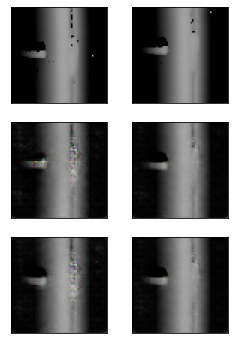

LEARNING STEP #  29 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 180s 29s/step - d_loss: 1.1986 - g_loss: 2.7247
Epoch 2/2
6/6 [==============================] - 179s 30s/step - d_loss: 1.2103 - g_loss: 2.8385


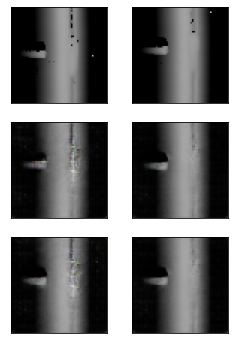

LEARNING STEP #  30 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 334s 60s/step - d_loss: 1.2169 - g_loss: 2.7372
Epoch 2/2
6/6 [==============================] - 214s 34s/step - d_loss: 1.2174 - g_loss: 2.6405


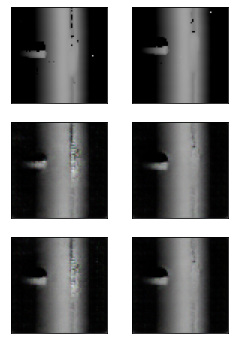

LEARNING STEP #  31 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 186s 31s/step - d_loss: 1.2218 - g_loss: 2.6455
Epoch 2/2
6/6 [==============================] - 184s 30s/step - d_loss: 1.2270 - g_loss: 2.5021


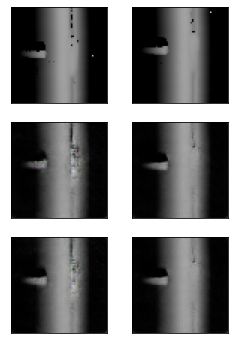

LEARNING STEP #  32 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 191s 32s/step - d_loss: 1.2081 - g_loss: 2.5760
Epoch 2/2
6/6 [==============================] - 185s 30s/step - d_loss: 1.2302 - g_loss: 2.6194


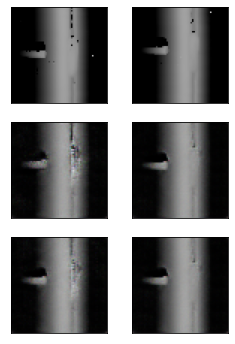

LEARNING STEP #  33 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 183s 30s/step - d_loss: 1.2137 - g_loss: 2.4494
Epoch 2/2
6/6 [==============================] - 183s 30s/step - d_loss: 1.2318 - g_loss: 2.5013


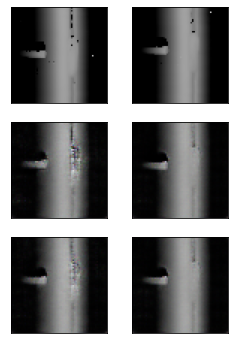

LEARNING STEP #  34 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 181s 30s/step - d_loss: 1.2176 - g_loss: 2.6200
Epoch 2/2
6/6 [==============================] - 182s 30s/step - d_loss: 1.2125 - g_loss: 2.7403


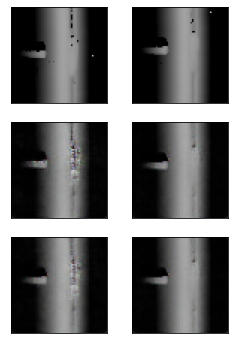

LEARNING STEP #  35 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 183s 30s/step - d_loss: 1.1719 - g_loss: 2.5882
Epoch 2/2
6/6 [==============================] - 184s 30s/step - d_loss: 1.1629 - g_loss: 2.4724


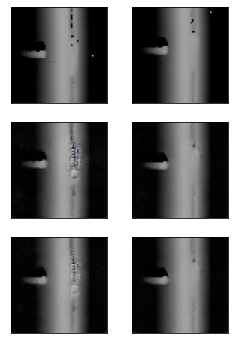

LEARNING STEP #  36 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 183s 30s/step - d_loss: 1.2126 - g_loss: 2.6976
Epoch 2/2
6/6 [==============================] - 182s 30s/step - d_loss: 1.2179 - g_loss: 2.7121


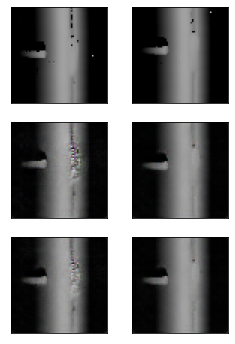

LEARNING STEP #  37 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 181s 30s/step - d_loss: 1.1748 - g_loss: 2.4054
Epoch 2/2
6/6 [==============================] - 181s 30s/step - d_loss: 1.1998 - g_loss: 2.8149


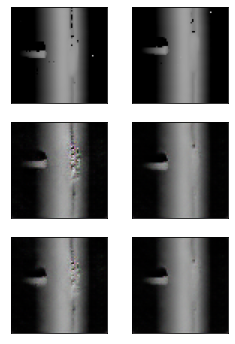

LEARNING STEP #  38 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 181s 30s/step - d_loss: 1.2215 - g_loss: 2.4995
Epoch 2/2
6/6 [==============================] - 180s 30s/step - d_loss: 1.2014 - g_loss: 2.7285


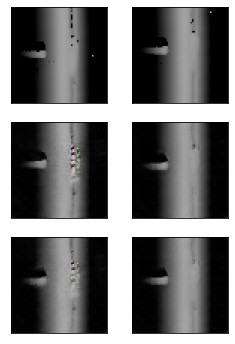

LEARNING STEP #  39 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 181s 30s/step - d_loss: 1.2324 - g_loss: 2.7567
Epoch 2/2
6/6 [==============================] - 180s 30s/step - d_loss: 1.1681 - g_loss: 2.4803


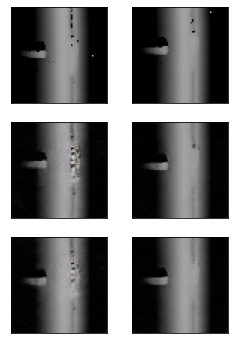

LEARNING STEP #  40 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 181s 30s/step - d_loss: 1.2381 - g_loss: 2.6555
Epoch 2/2
6/6 [==============================] - 181s 30s/step - d_loss: 1.2156 - g_loss: 2.6217


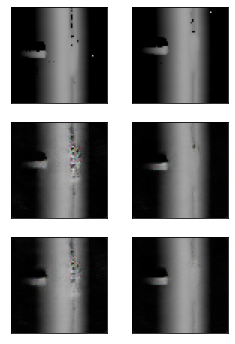

LEARNING STEP #  41 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 180s 29s/step - d_loss: 1.2631 - g_loss: 2.3835
Epoch 2/2
6/6 [==============================] - 181s 30s/step - d_loss: 1.1722 - g_loss: 2.7185


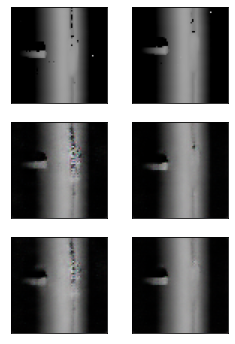

LEARNING STEP #  42 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 185s 31s/step - d_loss: 1.2036 - g_loss: 2.4145
Epoch 2/2
6/6 [==============================] - 183s 30s/step - d_loss: 1.1938 - g_loss: 2.5279


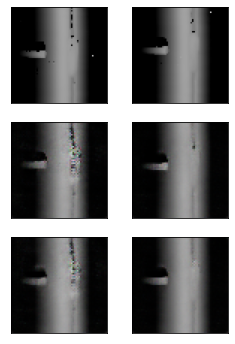

LEARNING STEP #  43 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 182s 30s/step - d_loss: 1.1667 - g_loss: 2.6253
Epoch 2/2
6/6 [==============================] - 183s 30s/step - d_loss: 1.1623 - g_loss: 2.6614


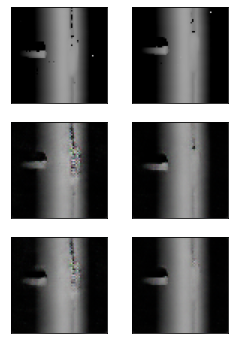

LEARNING STEP #  44 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 182s 30s/step - d_loss: 1.2026 - g_loss: 2.6895
Epoch 2/2
6/6 [==============================] - 181s 29s/step - d_loss: 1.1693 - g_loss: 2.4090


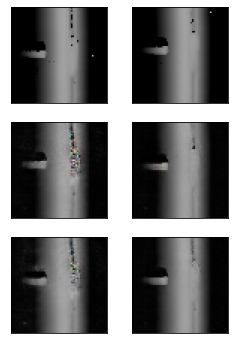

LEARNING STEP #  45 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 180s 29s/step - d_loss: 1.1439 - g_loss: 2.4946
Epoch 2/2
6/6 [==============================] - 181s 30s/step - d_loss: 1.1910 - g_loss: 2.5230


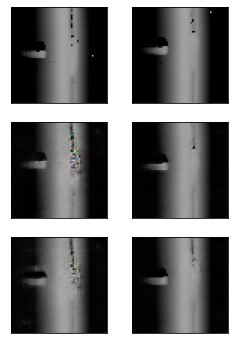

LEARNING STEP #  46 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 182s 30s/step - d_loss: 1.2142 - g_loss: 2.6300
Epoch 2/2
6/6 [==============================] - 181s 30s/step - d_loss: 1.1788 - g_loss: 2.8862


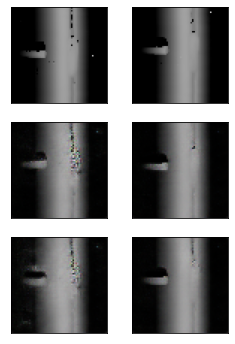

LEARNING STEP #  47 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 187s 31s/step - d_loss: 1.2180 - g_loss: 2.5522
Epoch 2/2
6/6 [==============================] - 184s 30s/step - d_loss: 1.1835 - g_loss: 2.4169


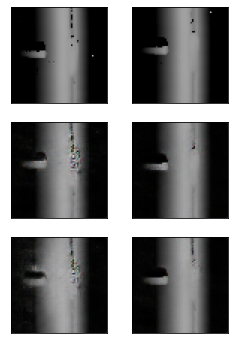

LEARNING STEP #  48 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 180s 29s/step - d_loss: 1.1653 - g_loss: 2.6806
Epoch 2/2
6/6 [==============================] - 181s 30s/step - d_loss: 1.1469 - g_loss: 2.6905


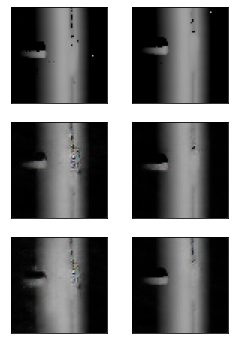

LEARNING STEP #  49 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 184s 30s/step - d_loss: 1.2080 - g_loss: 2.6920
Epoch 2/2
6/6 [==============================] - 180s 30s/step - d_loss: 1.1853 - g_loss: 2.5523


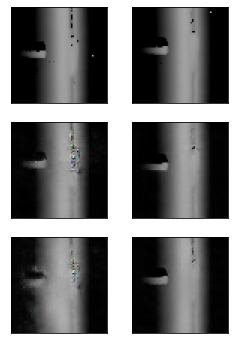

LEARNING STEP #  50 --------------------------------------------------
Epoch 1/2
6/6 [==============================] - 182s 30s/step - d_loss: 1.2344 - g_loss: 2.9580
Epoch 2/2
6/6 [==============================] - 181s 30s/step - d_loss: 1.2013 - g_loss: 2.7874


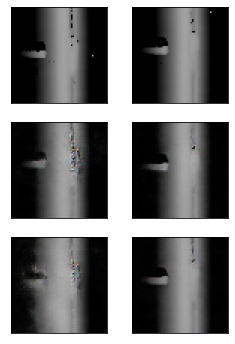

In [ ]:
############################# Start training #############################
LEARNING_STEPS = 50
for learning_step in range(LEARNING_STEPS):
    print('LEARNING STEP # ', learning_step + 1, '-' * 50)
    bagan_gp.fit(x_train, y_train, batch_size=128, epochs=2)
    d_loss_history += bagan_gp.history.history['d_loss']
    g_loss_history += bagan_gp.history.history['g_loss']
    if (learning_step+1)%1 == 0:
        plt_img(bagan_gp.generator, learning_step)

## Display performance

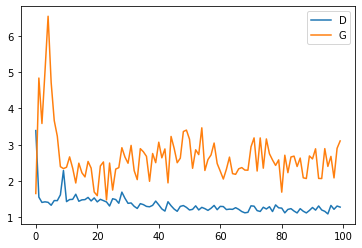

loading png... 0
loading png... 1
loading png... 2
loading png... 3
loading png... 4
loading png... 5
loading png... 6
loading png... 7
loading png... 8
loading png... 9
loading png... 10
loading png... 11
loading png... 12
loading png... 13
loading png... 14
loading png... 15
loading png... 16
loading png... 17
loading png... 18
loading png... 19
loading png... 20
loading png... 21
loading png... 22
loading png... 23
loading png... 24
loading png... 25
loading png... 26
loading png... 27
loading png... 28
loading png... 29
loading png... 30
loading png... 31
loading png... 32
loading png... 33
loading png... 34
loading png... 35
loading png... 36
loading png... 37
loading png... 38
loading png... 39
loading png... 40
loading png... 41
loading png... 42
loading png... 43
loading png... 44
loading png... 45
loading png... 46
loading png... 47
loading png... 48
loading png... 49
saving as gif...


In [ ]:
############################# Display performance #############################
# plot loss of G and D
plt.plot(d_loss_history, label='D')
plt.plot(g_loss_history, label='G')
plt.legend()
plt.show()

# save gif
import imageio
ims = []
for i in range(LEARNING_STEPS):
    fname = 'generated_plot_%d.png' % i
    dir = 'bagan_gp_results/'
    if fname in os.listdir(dir):
        print('loading png...', i)
        im = imageio.imread(dir + fname, 'png')
        ims.append(im)
print('saving as gif...')
imageio.mimsave(dir + 'training_demo.gif', ims, fps=3)

### Create a GIF


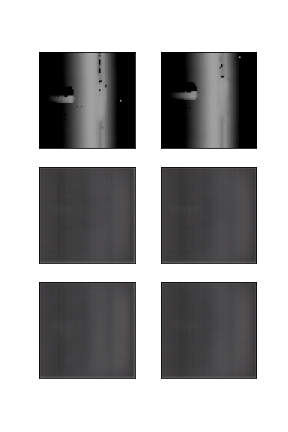

In [ ]:
import tensorflow_docs.vis.embed as embed
anim_file ='/content/bagan_gp_results/training_demo.gif'
embed.embed_file(anim_file)

# Summary of BAGAN-GP testing for imbalanced images generation
Although took longer training time compared with regular GAN, BAGAN-GP totally outperformed the regular GAN on imbalanced datasets:
1. Both majority and minority class images of Welds were generated in high quality and very convincing. 
2. very stable training process even for longer than required (~ about 5 hours), thanks to the gradient penalty term. 
3. The BAGAN-GP mitigates the problem of BAGAN that is unstable when images in different classes look similar. Especially, the good/bad weld images are actually quite similar and only difference is the weld seam area. The output bad images captured the differences that are critical for quality inspection. 




# References

1.   Deep Convolutional Generative Adversarial Network. https://www.tensorflow.org/tutorials/generative/dcgan 
2.   Huang, G., Jafari, A.H. Enhanced balancing GAN: minority-class image generation. Neural Comput & Applic (2021). https://doi.org/10.1007/s00521-021-06163-8 



